## XGB Base Model for Speech Emotion Recognition

### Import Required Libraries  

In [ ]:
!cat requirements.dev.txt

In [11]:
import pandas as pd 
import librosa
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder,  StandardScaler
import joblib

### Import Dataset 
> Make sure that the dataset is downsampled and augmented using the scripts provided

In [11]:
train_csv="/home/kayc/Code/Fuse/ASR-with-Speech-Sentiment-and-Text-Summarizer/notebook/output/train.csv"
df = pd.read_csv(train_csv) #Enter path after downsampling

### Encode emotions to numeric values

In [12]:
label_encoder = LabelEncoder()
df["Emotion_Code"] = label_encoder.fit_transform(df["Emotions"])

### Feature Extraction (Work in Progress)

> Currently consiering mfcc, chroma and contrast

In [4]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs_mean = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma_mean = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    contrast_mean = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    features = {}
    for i in range(13):
        features[f'mfccs_mean_{i}'] = mfccs_mean[i]
    for i in range(12):
        features[f'chroma_mean_{i}'] = chroma_mean[i]
    for i in range(7):
        features[f'contrast_mean_{i}'] = contrast_mean[i]
    return features

tqdm.pandas(desc="Extracting Features")

features_list = df['Path'].progress_apply(extract_features).tolist()
features_df = pd.DataFrame(features_list)

df = pd.concat([df, features_df], axis=1)

Extracting Features:  14%|█▍        | 6678/48408 [04:21<23:42, 29.34it/s]/home/kayc/Code/Fuse/ASR-with-Speech-Sentiment-and-Text-Summarizer/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting Features: 100%|██████████| 48408/48408 [28:32<00:00, 28.26it/s]


In [5]:
df.to_csv("features.csv", index = False)

### Create trainng and testing sets

In [2]:
df = pd.read_csv("features.csv")

In [3]:
scaler = StandardScaler()
X = df.drop(columns=['Path', 'Emotions', 'Emotion_Code'], axis=1)
X = scaler.fit_transform(X)
y = df['Emotion_Code']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create XGB model and train

In [5]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
}

In [6]:
model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(y.unique()))

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, verbose=10)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.413 total time=  22.8s
[CV 2/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.409 total time=  19.5s
[CV 3/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.413 total time=   9.1s
[CV 4/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 4/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.420 total time=  13.1s
[CV 5/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 5/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.417 total time=   8.2s
[CV 1/5; 2/27] START le

In [10]:
model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=7,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [8]:
joblib.dump(best_model, "model.pkl")

['model.pkl']

In [13]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [14]:
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

### Model evaluation

In [15]:
best_model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

In [16]:
y_pred = best_model.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

Accuracy: 65.08%
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1587
           1       0.59      0.54      0.57      1549
           2       0.65      0.57      0.61      1544
           3       0.57      0.57      0.57      1507
           4       0.62      0.70      0.66      1487
           5       0.65      0.69      0.67      1563
           6       0.90      0.87      0.88       445

    accuracy                           0.65      9682
   macro avg       0.67      0.67      0.67      9682
weighted avg       0.65      0.65      0.65      9682



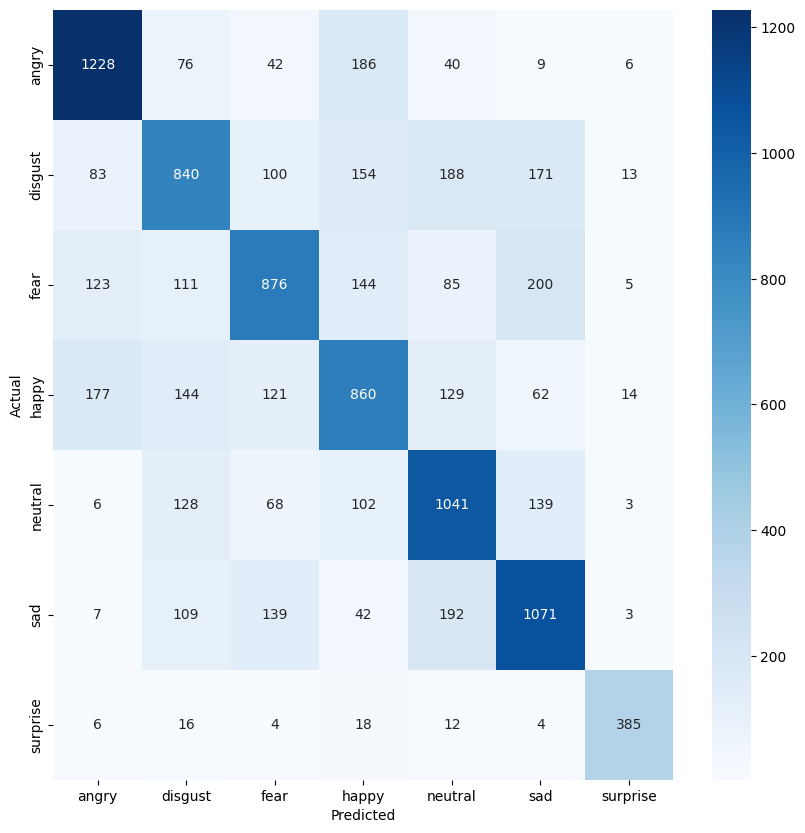

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap = "Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Inference

In [19]:
import pandas as pd
import librosa
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

In [20]:
best_model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

In [21]:
path = "/home/kayc/Code/Fuse/ASR-with-Speech-Sentiment-and-Text-Summarizer/notebook/output/clips/OAF_hit_angry_pitch.flac"  # Replace with your audio file

# Feature extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs_mean = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma_mean = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    contrast_mean = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    features = {}
    for i in range(13):
        features[f'mfccs_mean_{i}'] = mfccs_mean[i]
    for i in range(12):
        features[f'chroma_mean_{i}'] = chroma_mean[i]
    for i in range(7):
        features[f'contrast_mean_{i}'] = contrast_mean[i]
    return features

In [22]:
new_features = extract_features(path)

# Scale the features
new_features_df = pd.DataFrame([new_features])
new_features_scaled = scaler.transform(new_features_df)

In [23]:
y_pred = best_model.predict(new_features_scaled)
predicted_emotion = label_encoder.inverse_transform(y_pred)
print(f'Predicted Emotion: {predicted_emotion[0]}')

Predicted Emotion: angry
